## 2D SSN simulation ~  JAX IMPLEMENTATION

CHANGES:
- jax.random vs numpy.random
- introduction of key variables to operate in random
- np.chararray substituted -> created separate boolean array after locating indices in a list because jax doesnt support character arrays

In [1]:
#import numpy as np
import jax.numpy as np
from jax import jit
import matplotlib.pyplot as plt
from scipy.linalg import circulant, toeplitz
import time, os, json
import pandas as pd
from scipy import stats 
from tqdm import tqdm
import seaborn as sns
from jax import random

from util import Euler2fixedpt

In [2]:
#import SSN_classes

## SSN classes

SSN BASE

In [3]:

class _SSN_Base(object):
    def __init__(self, n, k, Ne, Ni, tau_vec=None, W=None):
        self.n = n
        self.k = k
        self.Ne = Ne
        self.Ni = Ni
        self.N = self.Ne + self.Ni
        #original code - not jax compatible
        #self.EI = np.chararray((self.N,), itemsize=1)
        #self.EI[:Ne] = b"E"
        #self.EI[Ne:] = b"I"
        
        ## JAX CHANGES ##
        self.EI=[b"E"]*(self.Ne) + [b"I"]*(self.N - self.Ne)
        self.condition= np.array([bool(self.EI[x]==b"E") for x in range(len(self.EI))])
        
        if tau_vec is not None:
            self.tau_vec = tau_vec # rate time-consants of neurons. shape: (N,)
        # elif  not hasattr(self, "tau_vec"):
        #     self.tau_vec = np.random.rand(N) * 20 # in ms
        if W is not None:
            self.W = W # connectivity matrix. shape: (N, N)
        # elif  not hasattr(self, "W"):
        #     W = np.random.rand(N,N) / np.sqrt(self.N)
        #     sign_vec = np.hstack(np.ones(self.Ne), -np.ones(self.Ni))
        #     self.W = W * sign_vec[None, :] # to respect Dale

    @property
    def neuron_params(self):
        return dict(n=self.n, k=self.k)

    @property
    def dim(self):
        return self.N

    @property
    def tau_x_vec(self):
        """ time constants for the generalized state-vector, x """
        return self.tau_vec


    def powlaw(self, u):
        return  self.k * np.maximum(0,u)**self.n

    def drdt(self, r, inp_vec):
        return ( -r + self.powlaw(self.W @ r + inp_vec) ) / self.tau_vec

    def drdt_multi(self, r, inp_vec):
        """
        Compared to self.drdt allows for inp_vec and r to be
        matrices with arbitrary shape[1]
        """
        return (( -r + self.powlaw(self.W @ r + inp_vec) ).T / self.tau_vec ).T

    def dxdt(self, x, inp_vec):
        """
        allowing for descendent SSN types whose state-vector, x, is different
        than the rate-vector, r.
        """
        return self.drdt(x, inp_vec)

    def gains_from_v(self, v):
        return self.n * self.k * np.maximum(0,v)**(self.n-1)

    def gains_from_r(self, r):
        return self.n * self.k**(1/self.n) * r**(1-1/self.n)

    def DCjacobian(self, r):
        """
        DC Jacobian (i.e. zero-frequency linear response) for
        linearization around rate vector r
        """
        Phi = self.gains_from_r(r)
        return -np.eye(self.N) + Phi[:, None] * self.W

    def jacobian(self, DCjacob=None, r=None):
        """
        dynamic Jacobian for linearization around rate vector r
        """
        if DCjacob is None:
            assert r is not None
            DCjacob = self.DCjacobian(r)
        return DCjacob / self.tau_x_vec[:, None] # equivalent to np.diag(tau_x_vec) * DCjacob

    def jacobian_eigvals(self, DCjacob=None, r=None):
        Jacob = self.jacobian(DCjacob=DCjacob, r=r)
        return np.linalg.eigvals(Jacob)

    def inv_G(self, omega, DCjacob, r=None):
        """
        inverse Green's function at angular frequency omega,
        for linearization around rate vector r
        """
        if DCjacob is None:
            assert r is not None
            DCjacob = self.DCjacobian(r)
        return -1j*omega * np.diag(self.tau_x_vec) - DCjacob

    def fixed_point_r(self, inp_vec, r_init=None, Tmax=500, dt=1, xtol=1e-5, PLOT=False, verbose=True):
        if r_init is None:
            r_init = np.zeros(inp_vec.shape) # np.zeros((self.N,))
        drdt = lambda r : self.drdt(r, inp_vec)
        if inp_vec.ndim > 1:
            drdt = lambda r : self.drdt_multi(r, inp_vec)
        r_fp, CONVG = Euler2fixedpt(drdt, r_init, Tmax, dt, xtol=xtol, PLOT=PLOT, verbose=verbose)
        if not CONVG:
            print('Did not reach fixed point.')
        #else:
        #    return r_fp
        return r_fp, CONVG

    def fixed_point(self, inp_vec, x_init=None, Tmax=500, dt=1, xtol=1e-5, PLOT=False):
        if x_init is None:
            x_init = np.zeros((self.dim,))
        dxdt = lambda x : self.dxdt(x, inp_vec)
        x_fp, CONVG = Euler2fixedpt(dxdt, x_init, Tmax, dt, xtol=xtol, PLOT=PLOT)
        if not CONVG:
            print('Did not reach fixed point.')
        #else:
        #    return x_fp
        return x_fp, CONVG

    def make_noise_cov(self, noise_pars):
        # the script assumes independent noise to E and I, and spatially uniform magnitude of noise
        noise_sigsq = np.hstack( (noise_pars.stdevE**2 * np.ones(self.Ne),
                                  noise_pars.stdevI**2 * np.ones(self.Ni)) )
        spatl_filt = np.array(1)

        return noise_sigsq, spatl_filt

SSN_AMPAGABA_BASE

In [4]:
class _SSN_AMPAGABA_Base(_SSN_Base):
    """
    SSN with different synaptic receptor types.
    Dynamics of the model assumes the instantaneous neural I/O approximation
    suggested by Fourcaud and Brunel (2002).
    Convention for indexing of state-vector v (which is 2N or 3N dim)
    is according to kron(receptor_type_index, neural_index).
    """
    def __init__(self,*, tau_s=[4,5,100], NMDAratio=0.4, **kwargs):
        """
        tau_s = [tau_AMPA, tau_GABA, tau_NMDA] or [tau_AMPA, tau_GABA]
          decay time-consants for synaptic currents of different receptor types.
        NMDAratio: scalar
          ratio of E synaptic weights that are NMDA-type
          (model assumes this fraction is constant in all weights)
        Good values:
         tau_AMPA = 4, tau_GABA= 5  #in ms
         NMDAratio = 0.3-0.4
         tau_s can have length == 3, and yet if self.NMDAratio is 0,
         then num_rcpt will be 2, and dynamical system will be 2 * self.N dimensional.
         I.e. NMDA components will not be simulated even though a NMDA time-constant is defined.
        """
        tau_s = np.squeeze(np.asarray(tau_s))
        assert tau_s.size <= 3 and tau_s.ndim == 1
        self._tau_s = tau_s
        if tau_s.size == 3 and NMDAratio > 0:
            self._NMDAratio = NMDAratio
        else:
            self._NMDAratio = 0

        super(_SSN_AMPAGABA_Base, self).__init__(**kwargs)

    @property
    def dim(self):
        return self.num_rcpt * self.N

    @property
    def num_rcpt(self):
        if not hasattr(self, '_num_rcpt'):
            self._num_rcpt = self._tau_s.size
            if self._num_rcpt == 3 and self.NMDAratio == 0:
                self._num_rcpt = 2
        return self._num_rcpt

    @property
    def NMDAratio(self):
        return self._NMDAratio

    @NMDAratio.setter
    def NMDAratio(self, value):
        # if value > 0, make sure an NMDA time-constant is defined
        if value > 0 and self._tau_s.size < 3:
            raise ValueError("No NMDA time-constant defined! Change tau_s first to add NMDA constant.")
        # if NMDAratio is going from 0 to nonzero or vice versa, then delete _num_rcpt and _Wrcpt (so they are made de novo when needed)
        if (value == 0 and self._NMDAratio > 0) or (value > 0 and self._NMDAratio == 0):
            del self._Wrcpt
            del self._num_rcpt
        self._NMDAratio = value

    @property
    def Wrcpt(self):
        if not hasattr(self, '_Wrcpt'): # cache it in _Wrcpt once it's been created
            W_AMPA = (1-self.NMDAratio)* np.hstack((self.W[:,:self.Ne], np.zeros((self.N,self.Ni)) ))
            W_GABA = np.hstack((np.zeros((self.N,self.Ne)), self.W[:,self.Ne:]))
            Wrcpt = [W_AMPA, W_GABA]
            if self.NMDAratio > 0:
                W_NMDA = self.NMDAratio/(1-self.NMDAratio) * W_AMPA
                Wrcpt.append(W_NMDA)
            self._Wrcpt = np.vstack(Wrcpt) # shape = (self.num_rcpt*self.N, self.N)
        return self._Wrcpt

    @property
    def tau_s(self):
        return self._tau_s  #[:self.num_rcpt]

    @tau_s.setter
    def tau_s(self, values):
        self._tau_s = values
        del self._tau_s_vec   ##QUESTION 1! DELETING?

    @property
    def tau_s_vec(self):
        if not hasattr(self, '_tau_s_vec'): # cache it once it's been created
            self._tau_s_vec = np.kron(self._tau_s[:self.num_rcpt], np.ones(self.N))
        return self._tau_s_vec

    @property
    def tau_x_vec(self):
        """ time constants for the generalized state-vector, x """ ##QUESTION 2! difference between x and s vec
        return self.tau_s_vec

    @property
    def tau_AMPA(self):
        return self._tau_s[0]

    @property
    def tau_GABA(self):
        return self._tau_s[1]

    @property
    def tau_NMDA(self):
        if len(self._tau_s) == 3:
            return self._tau_s[2]
        else:
            return None

    def dvdt(self, v, inp_vec):
        """
        Returns the AMPA/GABA/NMDA based dynamics, with the instantaneous
        neural I/O approximation suggested by Fourcaud and Brunel (2002).
        v and inp_vec are now of shape (self.num_rcpt * ssn.N,).
        """
        #total input to power law I/O is the sum of currents of different types:
        r = self.powlaw( v.reshape((self.num_rcpt, self.N)).sum(axis=0) )  ##QUESTION 3 - WHY NOT INPUT VEC IN POWER LAW
        return ( -v + self.Wrcpt @ r + inp_vec ) / self.tau_s_vec

    def dxdt(self, x, inp_vec):
        return self.dvdt(x, inp_vec)

    def DCjacobian(self, r):
        """
        DC Jacobian (i.e. zero-frequency linear response) for
        linearization around state-vector v, leading to rate-vector r
        """
        Phi = self.gains_from_r(r)
        return ( -np.eye(self.num_rcpt * self.N) +
                np.tile( self.Wrcpt * Phi[None,:] , (1, self.num_rcpt)) ) # broadcasting so that gain (Phi) varies by 2nd (presynaptic) neural index, and does not depend on receptor type or post-synaptic (1st) neural index


    def linear_power_spect(self, r_fp, noise_pars, freq_range, fnums, e_LFP,
                               gamma_range=[20,100], EIGS=False, EIGVECS=False):
        """
        Returns the power spectrum/a (PS) of "LFP" recorded on 1 or MULTIPLE
        "electrodes" or probes, in the noise-driven multi-synaptic SSN, in a
        SINGLE stimulus condition, by linearizing in noise around the noise-free
        fixed point for that stimulus. (The stimulus condition is specified
        by its fixed point "r_fp".)
        LFP is approximated as the total-input into neurons, averaged over a
        group of neurons according to columns of "e_LFP" which provide the
        averaging weights. Different columns of "e_LFP" correspond to different
        probes. Averaging would be accurate if all column-sums of e_LFP are 1.
        Also, since electrophysiologically, LFP corresponds to averaged input
        to Pyramidal cells, it's more biological if e_LFP is only zero
        on inhibitory rows.
        Other inputs:
        freq_range: two-element seq, specifying min and max freq's (in Hz)
                    over which PS is calculated.
        fnums: number of frequency grid-points to evaluate PS on in above range.
        gamma_range: min and max freq's (in Hz) of gamma-range, used for
                     calcualting total gamma power(s).
        e_LFP: shape = (N, n_probes), with each N-dim column being the projection
               or signature vector for a single LFP probe
        EIGS: if True, the dynamical Jacobian and its eigenvalues at "r_fp" are
              calculated.
        noise_pars: specifies parameters of noise. Following fields are used
                    (example values are what I had used for the SSNHomogRing model):
                noise_pars.stdevE = 1.5; Std of E noise
                noise_pars.stdevI = 1.5; Std of E noise
                noise_pars.corr_time = 5; correlation time of noise in ms
                noise_pars.corr_length = 0.5; correlation length of noise in angles; 0 doesn't work well..: too small response
                noise_pars.NMDAratio = 0; % of external noise fed to the NMDA channel (the rest goes to AMPA)
        example usage:
        powspecs = ssn.linear_power_spect(r_fp, high_levels.NoisePars(), freq_range=[10,100], fnums=50, e_LFP)
        # where powspecs.shape = (e_LFP.shape[1], fnums) or, if e_LFP.ndims==1, (fnums,).
        """
        noise_sigsq, spatl_filt = self.make_noise_cov(noise_pars)
        tau_corr = noise_pars.corr_time  /1000 # convert to seconds
        noiseNMDA = 0 if self.num_rcpt<3 else noise_pars.NMDAratio
        tau_s = np.diag(self.tau_s_vec) /1000 # convert to seconds

        J = self.DCjacobian(r_fp)

        ones_rcpt = np.ones(self.num_rcpt)
        if e_LFP.ndim > 1 and e_LFP.shape[1] > 1:  # case of many different LFP probes (stacked along 2nd axis of e_LFP)
            ones_rcpt = ones_rcpt[:, None]
            noise_sigsq = noise_sigsq[:, None]
        e_LFP1 = np.kron(ones_rcpt, e_LFP) # this tensor product by ones(...) is because of the unweighted sum of currents of different types inside the neuronal nonlinearity

        # calculate LFP power spectrum/a:
        fs = np.linspace(*freq_range,fnums) # grid of frequencies in Hz

        ws = 2*np.pi * fs # angular freq's (omega's) in Hz
        LFP_spectra = []
        for w in ws:
            vecE = np.linalg.solve( (-1j*w * tau_s - J).T.conj() , e_LFP1) # self.inv_G(w,J).T.conj() @ e_LFP1

            # ASSUME noise is only coming thru AMPA and NMDA channels (first and last N inds, resp)
            # AND both channels get same exact realization of noise, up to scaling (so noise cov is rank-deficient, with rank ssn.N instead of ssn.dim)
            vecE1 = (1-noiseNMDA) * vecE[:self.N]  + noiseNMDA * vecE[-self.N:]
            # account for spatial correlations in noise input
            if spatl_filt.size > 1:
                vecE = spatl_filt.T  @ vecE1
                vecE1 = vecE
            # power-spec of pink noise with time-constant tau_corr and variance 1, which is 2*\tau /abs(-i\omega*\tau + 1)^2 (FT of exp(-|t|/tau))
            noise_spect = 2* tau_corr/np.abs(-1j*w * tau_corr + 1)**2 # in Hz^{-1}

            LFP_spectra.append( np.sum(vecE1.conj() * (noise_sigsq * vecE1), axis=0) * noise_spect )

        # *2 to combine (the symmetric) power across positive and negative freq's:
        LFP_spectra = 2 * np.real(np.asarray(LFP_spectra))

        # calculate gamma power(s)
        df = fs[1]-fs[0]
        gamma_powers = np.sum(LFP_spectra[(gamma_range[0]<fs) & (fs<gamma_range[1])], axis=0) * df

        # calculate Jacobian and its eigenvalues
        if EIGS:
            Jacob = self.jacobian(J) # np.kron(1/self.tau_s, np.ones(self.N))[:,None] * J  # equivalent to diag(tau_s) J (math)
            if EIGVECS:
                JacobLams = np.linalg.eig(Jacob)
            else:
                JacobLams = np.linalg.eigvals(Jacob)
        else:
            Jacob = JacobLams = None

        return LFP_spectra.T, fs, gamma_powers, JacobLams, Jacob

        # # using numba compiled code:
        # Jacob = None if not EIGS else self.jacobian(J) # np.kron(1/ssn.tau_s, np.ones(ssn.N))[:,None] * J  # equivalent to diag(tau_s) J (math)
        # shp = (len(fs),) if e_LFP1.ndim == 1 else (len(fs), e_LFP1.shape[1])
        # return SSN_power_spec.linear_power_spect_loop(self.N, fs, 0*1j + e_LFP1, shp,
        #                         J, noise_sigsq, spatl_filt, noiseNMDA, tau_s,
        #                         tau_corr, np.asarray(gamma_range), EIGS, 0*1j + Jacob)



SSN2DTOPOV1

In [5]:

# =========================== 2D topographic models ============================
class SSN2DTopoV1(_SSN_Base):
    _Lring = 180

    def __init__(self, n, k, tauE, tauI, grid_pars, conn_pars, **kwargs):
        Ni = Ne = grid_pars.gridsize_Nx**2
        tau_vec = np.hstack([tauE * np.ones(Ne), tauI * np.ones(Ni)])

        super(SSN2DTopoV1, self).__init__(n=n, k=k, Ne=Ne, Ni=Ni,
                                    tau_vec=tau_vec, **kwargs)

        self.grid_pars = grid_pars
        self.conn_pars = conn_pars
        self._make_maps(grid_pars)
        if conn_pars is not None: # conn_pars = None allows for ssn-object initialization without a W
            self.make_W(**conn_pars)

    @property
    def neuron_params(self):
        return dict(n=self.n, k=self.k,
                    tauE=self.tau_vec[0], tauI=self.tau_vec[self.Ne])
    @property
    def maps_vec(self):
        return np.vstack([self.x_vec, self.y_vec, self.ori_vec]).T

    @property
    def center_inds(self):
        """ indices of center-E and center-I neurons """
        return np.where((self.x_vec==0) & (self.y_vec==0))[0]

    @property
    def x_vec_degs(self):
        return self.x_vec / self.grid_pars.magnif_factor

    @property
    def y_vec_degs(self):
        return self.y_vec / self.grid_pars.magnif_factor

    def xys2inds(self, xys=[[0,0]], units="degree"):
        """
        indices of E and I neurons at location (x,y) (by default in degrees).
        In:
            xys: array-like list of xy coordinates.
            units: specifies unit for xys. By default, "degree" of visual angle.
        Out:
            inds: shape = (2, len(xys)), inds[0] = vector-indices of E neurons
                                         inds[1] = vector-indices of I neurons
        """
        inds = []
        for xy in xys:
            if units == "degree": # convert to mm
                xy = self.grid_pars.magnif_factor * np.asarray(xy)
            distsq = (self.x_vec - xy[0])**2 + (self.y_vec - xy[1])**2
            inds.append([np.argmin(distsq[:self.Ne]), self.Ne + np.argmin(distsq[self.Ne:])])
        return np.asarray(inds).T

    def xys2Emapinds(self, xys=[[0,0]], units="degree"):
        """
        (i,j) of E neurons at location (x,y) (by default in degrees). ##QUESTION 4 - i,j of a neuron?
        In:
            xys: array-like list of xy coordinates.
            units: specifies unit for xys. By default, "degree" of visual angle.
        Out:
            map_inds: shape = (2, len(xys)), inds[0] = row_indices of E neurons in map
                                         inds[1] = column-indices of E neurons in map
        """
        vecind2mapind = lambda i: np.array([i % self.grid_pars.gridsize_Nx,
                                            i // self.grid_pars.gridsize_Nx])
        return vecind2mapind(self.xys2inds(xys)[0])

    def vec2map(self, vec):
        assert vec.ndim == 1
        Nx = self.grid_pars.gridsize_Nx
        if len(vec) == self.Ne:
            map = np.reshape(vec, (Nx, Nx))
        elif len(vec) == self.N:
            map = (np.reshape(vec[:self.Ne], (Nx, Nx)),
                   np.reshape(vec[self.Ne:], (Nx, Nx)))
        return map

    def _make_maps(self, grid_pars=None):
        if grid_pars is None:
            grid_pars = self.grid_pars
        else:
            self.grid_pars = grid_pars

        self._make_retinmap()
        self._make_orimap()

        return self.x_map, self.y_map, self.ori_map

    def _make_retinmap(self, grid_pars=None):
        """
        make square grid of locations with X and Y retinotopic maps
        """
        if grid_pars is None:
            grid_pars = self.grid_pars
        else:
            self.grid_pars = grid_pars
        if not hasattr(grid_pars, "gridsize_mm"):
            self.grid_pars.gridsize_mm = grid_pars.gridsize_deg * grid_pars.magnif_factor
        Lx = Ly = self.grid_pars.gridsize_mm
        Nx = Ny = grid_pars.gridsize_Nx
        dx = dy = Lx/(Nx - 1)
        self.grid_pars.dx = dx # in mm
        self.grid_pars.dy = dy # in mm

        xs = np.linspace(0, Lx, Nx)
        ys = np.linspace(0, Ly, Ny)
        [X, Y] = np.meshgrid(xs - xs[len(xs)//2], ys - ys[len(ys)//2]) # doing it this way, as opposed to using np.linspace(-Lx/2, Lx/2, Nx) (for which this fails for even Nx), guarantees that there is always a pixel with x or y == 0
        Y = -Y # without this Y decreases going upwards

        self.x_map = X
        self.y_map = Y
        self.x_vec = np.tile(X.ravel(), (2,))
        self.y_vec = np.tile(Y.ravel(), (2,))
        return self.x_map, self.y_map

    def _make_orimap(self, hyper_col=None, nn=30, X=None, Y=None):
        '''
        Makes the orientation map for the grid, by superposition of plane-waves. ##QUESTIUON 5 - superposition?
        hyper_col = hyper column length for the network in retinotopic degrees
        nn = (30 by default) # of planewaves used to construct the map

        Outputs/side-effects:
        OMap = self.ori_map = orientation preference for each cell in the network
        self.ori_vec = vectorized OMap
        '''
        if hyper_col is None:
             hyper_col = self.grid_pars.hyper_col
        else:
             self.grid_pars.hyper_col = hyper_col
        X = self.x_map if X is None else X
        Y = self.y_map if Y is None else Y

        z = np.zeros_like(X)
        for j in range(nn):
            kj = np.array([np.cos(j * np.pi/nn), np.sin(j * np.pi/nn)]) * 2*np.pi/(hyper_col)
            
            ## JAX CHANGES ##
            key = random.PRNGKey(87)
            key, subkey = random.split(key)
            sj = 2 *random.randint(key=key, shape=[1,1], minval=0, maxval=2)-1 #random number that's either + or -1.
            key, subkey = random.split(key)
            phij = random.uniform(key, shape=[1,1], minval=0, maxval=1)*2*np.pi

            tmp = (X*kj[0] + Y*kj[1]) * sj + phij
            z = z + np.exp(1j * tmp)

        # ori map with preferred orientations in the range (0, _Lring] (i.e. (0, 180] by default)
        self.ori_map = (np.angle(z) + np.pi) * SSN2DTopoV1._Lring/(2*np.pi)
        # #for debugging/testing:
        # self.ori_map = 180 * (self.y_map - self.y_map.min())/(self.y_map.max() - self.y_map.min())
        # self.ori_map[self.ori_map.shape[0]//2+1:,:] = 180
        self.ori_vec = np.tile(self.ori_map.ravel(), (2,))
        return self.ori_map

    def _make_distances(self, PERIODIC):
        Lx = Ly = self.grid_pars.gridsize_mm
        absdiff_ring = lambda d_x, L: np.minimum(np.abs(d_x), L - np.abs(d_x))
        if PERIODIC:
            absdiff_x = absdiff_y = lambda d_x: absdiff_ring(d_x, Lx + self.grid_pars.dx)
        else:
            absdiff_x = absdiff_y = lambda d_x: np.abs(d_x)
        xs = np.reshape(self.x_vec, (2, self.Ne, 1)) # (cell-type, grid-location, None)
        ys = np.reshape(self.y_vec, (2, self.Ne, 1)) # (cell-type, grid-location, None)
        oris = np.reshape(self.ori_vec, (2, self.Ne, 1)) # (cell-type, grid-location, None)
        # to generalize the next two lines, can replace 0's with a and b in range(2) (pre and post-synaptic cell-type indices)
        xy_dist = np.sqrt(absdiff_x(xs[0] - xs[0].T)**2 + absdiff_y(ys[0] - ys[0].T)**2)
        ori_dist = absdiff_ring(oris[0] - oris[0].T, SSN2DTopoV1._Lring)
        self.xy_dist = xy_dist
        self.ori_dist = ori_dist

        return xy_dist, ori_dist  

    
    def make_W(self, J_2x2, s_2x2, p_local, sigma_oris=45, Jnoise=0,
                Jnoise_GAUSSIAN=True, MinSyn=1e-4, CellWiseNormalized=True,
                                                    PERIODIC=True): #, prngKey=0):
        """
        make the full recurrent connectivity matrix W
        In:
         J_2x2 = total strength of weights of different pre/post cell-type
         s_2x2 = ranges of weights between different pre/post cell-type
         p_local = relative strength of local parts of E projections
         sigma_oris = range of wights in terms of preferred orientation difference

        Output/side-effects:
        self.W
        """
        conn_pars = locals()
        conn_pars.pop("self")
        self.conn_pars = conn_pars

        if hasattr(self, "xy_dist") and hasattr(self, "ori_dist"):
            xy_dist = self.xy_dist
            ori_dist = self.ori_dist
        else:
            xy_dist, ori_dist = self._make_distances(PERIODIC)

        if np.isscalar(sigma_oris): sigma_oris = sigma_oris * np.ones((2,2))

        if np.isscalar(p_local) or len(p_local) == 1:
            p_local = np.asarray(p_local) * np.ones(2)

        Wblks = [[1,1],[1,1]]
        # loop over post- (a) and pre-synaptic (b) cell-types
        for a in range(2):
            for b in range(2):
                if b == 0: # E projections
                    W = np.exp(-xy_dist/s_2x2[a,b] -ori_dist**2/(2*sigma_oris[a,b]**2))
                elif b == 1: # I projections
                    W = np.exp(-xy_dist**2/(2*s_2x2[a,b]**2) -ori_dist**2/(2*sigma_oris[a,b]**2))

                if Jnoise > 0: # add some noise
                    if Jnoise_GAUSSIAN:
                        ##JAX CHANGES##
                        #jitter = np.random.standard_normal(W.shape)
                        key = random.PRNGKey(87)
                        key, subkey=random.split(key)
                        jitter = random.normal(key, W.shape)
                    else:
                        ##JAX CHANGES##
                       #jitter = 2* np.random.random(W.shape) - 1
                        key = random.PRNGKey(87)
                        key, subkey=random.split(key)
                        jitter = 2* random.uniform(key, W.shape) - 1
                    W = (1 + Jnoise * jitter) * W

                # sparsify (set small weights to zero)
                W = np.where(W < MinSyn, 0, W) # what's the point of this if not using sparse matrices

                # row-wise normalize
                tW = np.sum(W, axis=1)
                if not CellWiseNormalized:
                    tW = np.mean(tW)
                W = W / tW

                # for E projections, add the local part
                # NOTE: alterntaively could do this before adding noise & normalizing
                if b == 0:
                    W = p_local[a] * np.eye(*W.shape) + (1-p_local[a]) * W

                Wblks[a][b] = J_2x2[a, b] * W

        self.W = np.block(Wblks)
        return self.W

    def _make_inp_ori_dep(self, ONLY_E=False, ori_s=None, sig_ori_EF=32, sig_ori_IF=None, gE=1, gI=1):
        """
        makes the orintation dependence factor for grating or Gabor stimuli
        (a la Ray & Maunsell 2010)
        """
        if ori_s is None:  # set stim ori to pref ori of grid center E cell (same as I cell)
            ##JAX CHANGES##
            #ori_s = self.ori_vec[(self.x_vec==0) & (self.y_vec==0) & (self.EI==b"E")]
            ori_s = self.ori_vec[(self.x_vec==0) & (self.y_vec==0) & self.condition]
        if sig_ori_IF is None:
            sig_ori_IF = sig_ori_EF

        distsq = lambda x: np.minimum(np.abs(x), SSN2DTopoV1._Lring - np.abs(x))**2
        dori = self.ori_vec - ori_s
        if not ONLY_E:
            ori_fac = np.hstack((gE * np.exp(-distsq(dori[:self.Ne])/(2* sig_ori_EF**2)),
                                 gI * np.exp(-distsq(dori[self.Ne:])/(2* sig_ori_IF**2))))
        else:
            ori_fac = gE * np.exp(-distsq(dori[:self.Ne])/(2* sig_ori_EF**2))

        return ori_fac

    def make_grating_input(self, radius_s, sigma_RF=0.4, ONLY_E=False,
            ori_s=None, sig_ori_EF=32, sig_ori_IF=None, gE=1, gI=1, contrast=1):
        """
        make grating external input centered on the grid-center, with radius "radius",
        with edge-fall-off scale "sigma_RF", with orientation "ori_s",
        with the orientation tuning-width of E and I parts given by "sig_ori_EF"
        and "sig_ori_IF", respectively, and with amplitue (maximum) of the E and I parts,
        given by "contrast * gE" and "contrast * gI", respectively.
        If ONLY_E=True, it only makes the E-part of the input vector.
        """
        # make the orintation dependence factor:
        ori_fac = self._make_inp_ori_dep(ONLY_E, ori_s, sig_ori_EF, sig_ori_IF, gE, gI)

        # make the spatial envelope:
        sigmoid = lambda x: 1/(1 + np.exp(-x))
        M = self.Ne if ONLY_E else self.N
        r_vec = np.sqrt(self.x_vec_degs[:M]**2 + self.y_vec_degs[:M]**2)
        spat_fac = sigmoid((radius_s - r_vec)/sigma_RF)

        return contrast * ori_fac * spat_fac

    def make_gabor_input(self, sigma_Gabor=0.5, ONLY_E=False,
            ori_s=None, sig_ori_EF=32, sig_ori_IF=None, gE=1, gI=1, contrast=1):
        """
        make the Gabor stimulus (a la Ray & Maunsell 2010) centered on the
        grid-center, with sigma "sigma_Gabor",
        with orientation "ori_s",
        with the orientation tuning-width of E and I parts given by "sig_ori_EF"
        and "sig_ori_IF", respectively, and with amplitue (maximum) of the E and I parts,
        given by "contrast * gE" and "contrast * gI", respectively.
        """
        # make the orintation dependence factor:
        ori_fac = self._make_inp_ori_dep(ONLY_E, ori_s, sig_ori_EF, sig_ori_IF, gE, gI)

        # make the spatial envelope:
        gaussian = lambda x: np.exp(- x**2 / 2)
        M = self.Ne if ONLY_E else self.N
        r_vec = np.sqrt(self.x_vec_degs[:M]**2 + self.y_vec_degs[:M]**2)
        spat_fac = gaussian(r_vec/sigma_Gabor)

        return contrast * ori_fac * spat_fac

    # TODO:
    # def make_noise_cov(self, noise_pars):
    #     # the script assumes independent noise to E and I, and spatially uniform magnitude of noise
    #     noise_sigsq = np.hstack( (noise_pars.stdevE**2 * np.ones(self.Ne),
    #                            noise_pars.stdevI**2 * np.ones(self.Ni)) )
    #
    #     spatl_filt = ...

    def make_eLFP_from_inds(self, LFPinds):
        """
        makes a single LFP electrode signature (normalized spatial weight
        profile), given the (vectorized) indices of recorded neurons (LFPinds).

        OUT: e_LFP with shape (self.N,)
        """
        # LFPinds was called LFPrange in my MATLAB code
        if LFPinds is None:
            LFPinds = [0]
        e_LFP = 1/len(LFPinds) * np.isin(np.arange(self.N), LFPinds) # assuming elements of LFPinds are all smaller than self.Ne, e_LFP will only have 1's on E elements
        # eI = 1/len(LFPinds) * np.isin(np.arange(self.N) - self.Ne, LFPinds) # assuming elements of LFPinds are all smaller than self.Ne, e_LFP will only have 1's on I elements

        return e_LFP

    def make_eLFP_from_xy(self, probe_xys, LFPradius=0.2, unit_xys="degree", unit_rad="mm"):
        """
        makes 1 or multiple LFP electrodes signatures (normalized spatial weight
        profile over E cells), given the (x,y) retinotopic coordinates of LFP probes.

        IN: probe_xys: shape (#probes, 2). Each row is the (x,y) coordinates of
                 a probe/electrode (by default given in degrees of visual angle)
             LFPradius: positive scalar. radius/range of LFP (by default given in mm)
            unit_xys: either "degree" or "mm", unit of LFP_xys
            unit_rad: either "degree" or "mm", unit of LFPradius
        OUT: e_LFP: shape (self.N, #probes) = (self.N, LFP.xys.shape[0])
             Each column is the normalized spatial profile of one probe.
        """
        if unit_rad == "degree":
            LFPradius = self.grid_pars.magnif_factor * LFPradius

        e_LFP = []
        for xy in probe_xys:
            if unit_xys == "degree": # convert to mm
                xy = self.grid_pars.magnif_factor * np.asarray(xy)
            e_LFP.append(1.0 * ( (self.EI == b"E") &
            (LFPradius**2 > (self.x_vec - xy[0])**2 + (self.y_vec - xy[1])**2)))

        return np.asarray(e_LFP).T



class SSN2DTopoV1_AMPAGABA(SSN2DTopoV1, _SSN_AMPAGABA_Base):
    pass


### Common parameters

In [6]:
class ssn_pars():
    n = 2
    k = 0.04
    tauE = 30 # in ms
    tauI = 10 # in ms
    psi = 0.774
    tau_s = np.array([5, 7, 100]) #in ms, AMPA, GABA, NMDA current decay time constants
    make_J2x2 = lambda Jee, Jei, Jie, Jii: np.array([[Jee, -Jei], [Jie,  -Jii]]) * np.pi * ssn_pars.psi

# with mm_scale=1, The following match "fixed_params" of  'Fig4_data-retinoHists-samples1000_TauCorr5_2020-04-11.json'
class grid_pars():
    gridsize_Nx = 8 + 1 # grid-points across each edge # gives rise to dx = 0.8 mm
    gridsize_deg = 2 * 1.6 # edge length in degrees
    magnif_factor = 2  # mm/deg
    hyper_col = 0.8 # mm   
    sigma_RF = 0.4 # deg (visual angle)

# Caleb's params for the full (with local) model:
Js0 = [1.82650658, 0.68194475, 2.06815311, 0.5106321]
gE, gI = 0.57328625, 0.26144141
sigEE, sigIE = 0.2, 0.40
sigEI, sigII = .09, .09
conn_pars = dict(
    PERIODIC = False,
    J_2x2 = ssn_pars.make_J2x2(*Js0),
    s_2x2 = np.array([[sigEE, sigEI],[sigIE, sigII]]), # in mm
    p_local = [.4, 0.7], # [p_local_EE, p_local_IE],
    sigma_oris = 1000)  # sigma_oris
conn_pars['J_2x2'] = ssn_pars.make_J2x2(*Js0)

In [7]:

ssn = SSN2DTopoV1_AMPAGABA(ssn_pars.n, ssn_pars.k, ssn_pars.tauE,
              ssn_pars.tauI, grid_pars, conn_pars=conn_pars, tau_s=ssn_pars.tau_s)

## Try finding fixed point with input

Input parameters - actual inp not valid (remove add noise 

In [8]:
I2Eexcit = 0;
spont_input = np.array([1,1]) * 3

contrast = 50
grid_pars.sig_ori_EF = 32 # deg (ori)

lcorr_noise_grid = 2.6
rel_sigma_noise = 0.2
sigma_noise = .2 # rel_sigma_noise * contrast
I2E_noise = 2

dt = 1
xtol = 1e-5
Tmax = 200

In [9]:
ssn = SSN2DTopoV1_AMPAGABA(ssn_pars.n, ssn_pars.k, ssn_pars.tauE,
              ssn_pars.tauI, grid_pars, conn_pars=conn_pars, tau_s=ssn_pars.tau_s)

inp0 = contrast * ssn.make_grating_input(radius_s=grid_pars.gridsize_deg * 5, sigma_RF=grid_pars.sigma_RF,
                                sig_ori_EF=grid_pars.sig_ori_EF, gE=gE, gI=gI)

r_init = np.zeros(inp0.shape)

inp = inp0 + np.kron(spont_input +   np.array([1,I2Eexcit]), np.ones(ssn.Ne))

r_fps, CONVG = ssn.fixed_point_r(inp, r_init=r_init, Tmax=Tmax, dt=dt, xtol=xtol)


 Warning 1: reached Tmax=200, before convergence to fixed point.
       max(abs(dx./max(abs(xvec), 1.0))) = 0.00030497164698317647,   xtol=1e-05.

Did not reach fixed point.


In [18]:
grid_pars.magnif_factor

2

## Gabor function implementation

###need to consider if in degrees or in mm!! 

In [68]:
class gabor_filter:
    
    def __init__(self, x_i, y_i, k, sigma_g, theta, phase=0, conv_factor=None):
        
        '''
        Gabor filter class.
        Inputs:
            x_i, y_i: centre of filter
            k: preferred spatial frequency in cycles/degrees (radians)
            sigma_g: variance of Gaussian function
            theta: preferred oritnation 
            conv_factor: conversion factor from degrees to mm
        '''
        
        #convert to mm from degrees
        if conv_factor:
            self.x_i=x_i*conv_factor
            self.y_i=y_i*conv_factor
        else:
            self.x_i=x_i
            self.y_i=y_i
        self.k=k*2*np.pi #preferred spatial frequency
        self.theta=theta*(np.pi/180) #preferred orientation - convert to radians
        self.phase=phase 
        self.sigma_g=sigma_g
        
    def apply_filter(self, x,y):
        spatial=np.cos(self.k*(x-self.x_i)*np.cos(self.theta) + self.k*(y-self.y_i)*np.sin(self.theta) + self.phase) 
        gabor= np.exp(-0.5 *( (x-self.x_i)**2 + (y-self.y_i)**2)/self.sigma_g**2)
        return gabor*spatial

Test single filter

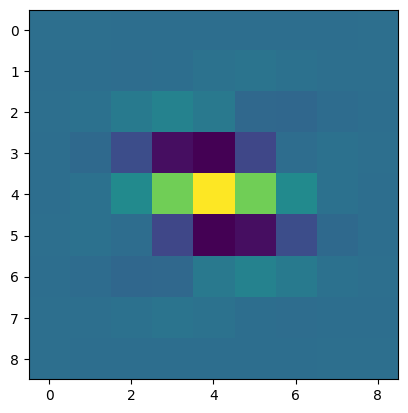

In [69]:
test_filter=gabor_filter(x_i=0, y_i=0, k=0.5, sigma_g=1, theta=10, conv_factor=grid_pars.magnif_factor)
x_axis=np.linspace(-3.2, 3.2, 9)
y_axis=np.linspace(-3.2, 3.2, 9)
values=[]
for x in x_axis:
    for y in y_axis:
        val=test_filter.apply_filter(x,y)
        values.append(val)
values=np.array(values).reshape(9,9)
plt.imshow(values)

Iterate through all neurons

In [79]:
##iterate through all the maps to obtain different gabor filters
all_filters=[]
x_axis=np.linspace(-3.2, 3.2, 9)
y_axis=np.linspace(-3.2, 3.2, 9)

for i in range(ssn.ori_map.shape[0]):
    for j in range(ssn.ori_map.shape[0]):
        gabor=gabor_filter(x_i=ssn.x_map[i,j], y_i=ssn.y_map[i,j], k=0.5, sigma_g=1, theta=ssn.ori_map[i,j], conv_factor=grid_pars.magnif_factor)
        values=[]
        
        for x in x_axis:
            for y in y_axis:
                val=gabor.apply_filter(x,y)
                values.append(val)   
        all_filters.append(np.array(values).reshape(9,9))         


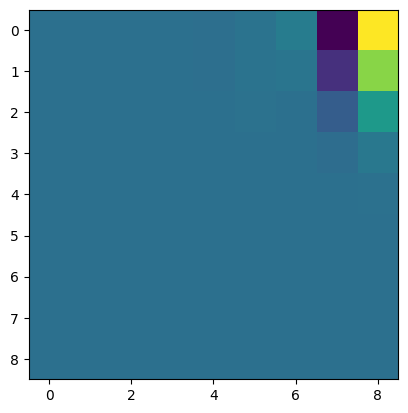